# Solving different instance classes with QAOA and VQE in `qiskit`


Consider an $n$-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij} \geq 0$, $w_{ij} = w_{ji}$ for $(i, j) \in E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut.



## Things for SPARTAN RUN

- y = Mean(Energy Gap)
- f(x) := {Set of Features from Fens thesis}
- Optimization = COBYLA
- 10 restarts
- 5 instances types
	- 30 of each type
- Algorithm:
	- VQE
        - 10 paramaters
        - 20 parameters
        - 30 parameters
    - QAOA
        - **PASS**
        - More layers >> better
- 150 runs
- Maximum # of Function Evaluations is 1000\*G.nodes() (look at n layers, 1:N)
    - Better in more or LESS layers
    
    

In [80]:
import pylab
%matplotlib inline
import numpy as np
import json
import networkx as nx
import random
import copy
# useful additional packages
import numpy as np
import networkx as nx
import seaborn as sns

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

import sys
sys.path.append("../")
from qaoa_vrp.features.graph_features import *

import mlflow

sns.set_theme()


In [81]:
import qiskit
qiskit.__version__

'0.21.2'

# Types of Instances

We are going to investigate the following types of instances:

1. **Uniform Random Graphs** -- graph edges chosen at random
2. **Power Law Trees** -- trees with power law degree distribution where the exponent is chosen to be 3
3. **Watts-Strogatz small world graphs** - graphs with high clustering coefficient, small average path length
4. **Geometric Graphs** -- graph nodes are placed uniformly at random inside the unit cube with a max distaince between the nodes of 4
5. **Nearly Complete BiPartite graphs** -- graphs that have had 1 to 3 edges added or removed from a complete bipartite graph

In [82]:
class GraphInstance:
    def __init__(self, G, graph_type):
        self.G = G
        self.graph_type = graph_type
        self.weight_matrix = None
        self.brute_force_sol = None
        
    def __repr__(self):
        return f"This is a {self.graph_type} {self.G} graph instance"
    
    def allocate_random_weights(self):
        # Allocate random costs to the edges for now
        for (u, v) in self.G.edges():
            self.G.edges[u,v]['weight'] = random.randint(0,10)
        
    
    def compute_weight_matrix(self):
        G = self.G
        n = len(G.nodes())
        w = np.zeros([n,n])
        for i in range(n):
            for j in range(n):
                temp = G.get_edge_data(i,j,default=0)
                if temp != 0:
                    w[i,j] = temp['weight']
        self.weight_matrix = w
        
    def show_weight_matrix(self):
        print(self.weight_matrix)
        
    def build_qubo():
        pass
    
    def solve_qaoa():
        pass
    
    def solve_vqe():
        pass

In [83]:
# Number of nodes
N = 10

# Generating a graph of 10 nodes
G_unif = GraphInstance(nx.gnm_random_graph(N, 30), "Uniform Random")
G_pl_tree = GraphInstance(nx.random_powerlaw_tree(N, gamma=3, seed=None, tries=1000), "Power Law Tree")
G_wattz = GraphInstance(nx.connected_watts_strogatz_graph(N,k=4,p=0.5), "Watts-Strogatz small world")
G_geom = GraphInstance(nx.random_geometric_graph(N, radius=4), "Geometric")
G_nc_bipart = GraphInstance(nx.complete_bipartite_graph(int(N/2),int(N/2)), "Nearly Complete BiPartite")


G_instances = [G_unif, G_pl_tree, G_wattz, G_geom, G_nc_bipart]


--------------------------------------------------
Running Experiment for Uniform Random
--------------------------------------------------

Instance Features for Uniform Random
--------------------------------------------------

{
    "acyclic": false,
    "algebraic_connectivity": 3.3032230809485585,
    "average_distance": 1.3333333333333333,
    "bipartite": false,
    "clique_number": 5,
    "connected": true,
    "density": 0.6666666666666666,
    "diameter": 2,
    "edge_connectivity": 4,
    "eulerian": false,
    "laplacian_largest_eigenvalue": 10.00000000000002,
    "maximum_degree": 9,
    "minimum_degree": 4,
    "minimum_dominating_set": 2,
    "number_of_components": 1,
    "number_of_edges": 30,
    "number_of_vertices": 10,
    "planar": false,
    "radius": 1,
    "regular": false,
    "laplacian_second_largest_eigenvalue": 3.30322308094855,
    "ratio_of_two_largest_laplacian_eigenvaleus": 3.0273462478738886,
    "smallest_eigenvalue": 0.0,
    "vertex_connectivity":

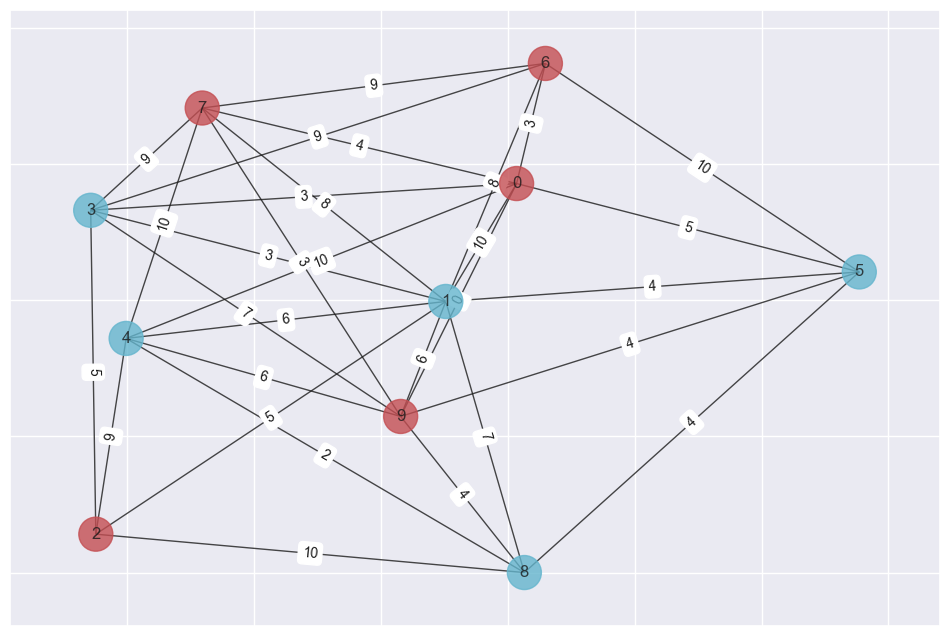

Problem name: Max-cut

Maximize
  -20*x_0*x_1 - 6*x_0*x_3 - 20*x_0*x_4 - 10*x_0*x_5 - 6*x_0*x_6 - 8*x_0*x_7
  - 10*x_1*x_2 - 6*x_1*x_3 - 12*x_1*x_4 - 8*x_1*x_5 - 16*x_1*x_6 - 16*x_1*x_7
  - 14*x_1*x_8 - 12*x_1*x_9 - 10*x_2*x_3 - 18*x_2*x_4 - 20*x_2*x_8 - 18*x_3*x_6
  - 18*x_3*x_7 - 14*x_3*x_9 - 20*x_4*x_7 - 4*x_4*x_8 - 12*x_4*x_9 - 20*x_5*x_6
  - 8*x_5*x_8 - 8*x_5*x_9 - 18*x_6*x_7 - 6*x_7*x_9 - 8*x_8*x_9 + 35*x_0 + 57*x_1
  + 29*x_2 + 36*x_3 + 43*x_4 + 27*x_5 + 39*x_6 + 43*x_7 + 27*x_8 + 30*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -91.5
Ising Hamiltonian:
5.0 * IIIIIIIIZZ
+ 2.5 * IIIIIIIZZI
+ 1.5 * IIIIIIZIIZ
+ 1.5 * IIIIIIZIZI
+ 2.5 * IIIIIIZZII
+ 5.0 * IIIIIZIIIZ
+ 3.0 * IIIIIZIIZI
+ 4.5 * IIIIIZIZII
+ 2.5 * IIIIZIIIIZ
+ 2.0 * IIIIZIIIZI
+ 1.5 * IIIZIIIIIZ
+ 4.0 * IIIZIIIIZI
+ 4.5 * IIIZIIZIII
+ 5.0 * IIIZZIIIII
+ 2.0 * IIZIIIIIIZ
+ 4.0 * IIZIIIIIZI
+ 4.5 * IIZIIIZIII
+ 5.0 * IIZIIZIIII
+ 4.5 * IIZZIIIIII
+ 3.5 * I

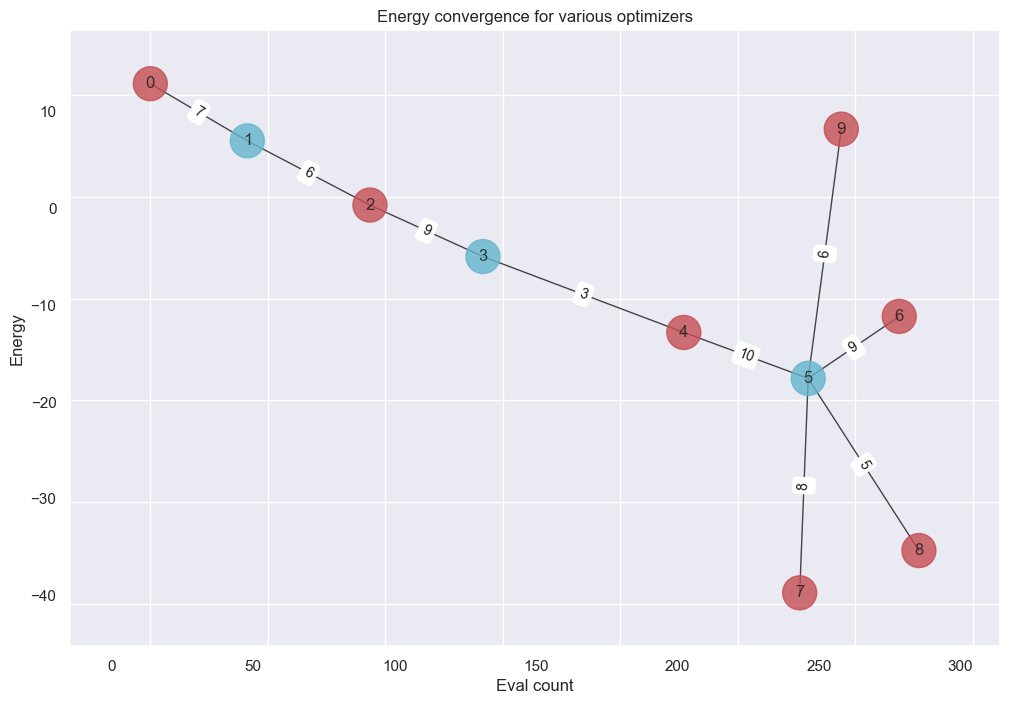

Problem name: Max-cut

Maximize
  -14*x_0*x_1 - 12*x_1*x_2 - 18*x_2*x_3 - 6*x_3*x_4 - 20*x_4*x_5 - 18*x_5*x_6
  - 16*x_5*x_7 - 10*x_5*x_8 - 12*x_5*x_9 + 7*x_0 + 13*x_1 + 15*x_2 + 12*x_3
  + 13*x_4 + 38*x_5 + 9*x_6 + 8*x_7 + 5*x_8 + 6*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -31.5
Ising Hamiltonian:
3.5 * IIIIIIIIZZ
+ 3.0 * IIIIIIIZZI
+ 4.5 * IIIIIIZZII
+ 1.5 * IIIIIZZIII
+ 5.0 * IIIIZZIIII
+ 4.5 * IIIZZIIIII
+ 4.0 * IIZIZIIIII
+ 2.5 * IZIIZIIIII
+ 3.0 * ZIIIZIIIII
objective function value: 63.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=1.0, x_9=1.0
status: SUCCESS

Best solution BRUTE FORCE = [0, 1, 0, 1, 0, 1, 0, 0, 0, 0] cost = 63.0

---------- Checking that current Hamiltonian gives right cost ----------

ground state energy: -31.5
optimal max-cut objective: -63.0
ground state solution: [1 0 1 0 1 0 1 1 1 1]
ground state objective: 0.0

---------- Simulating Insta

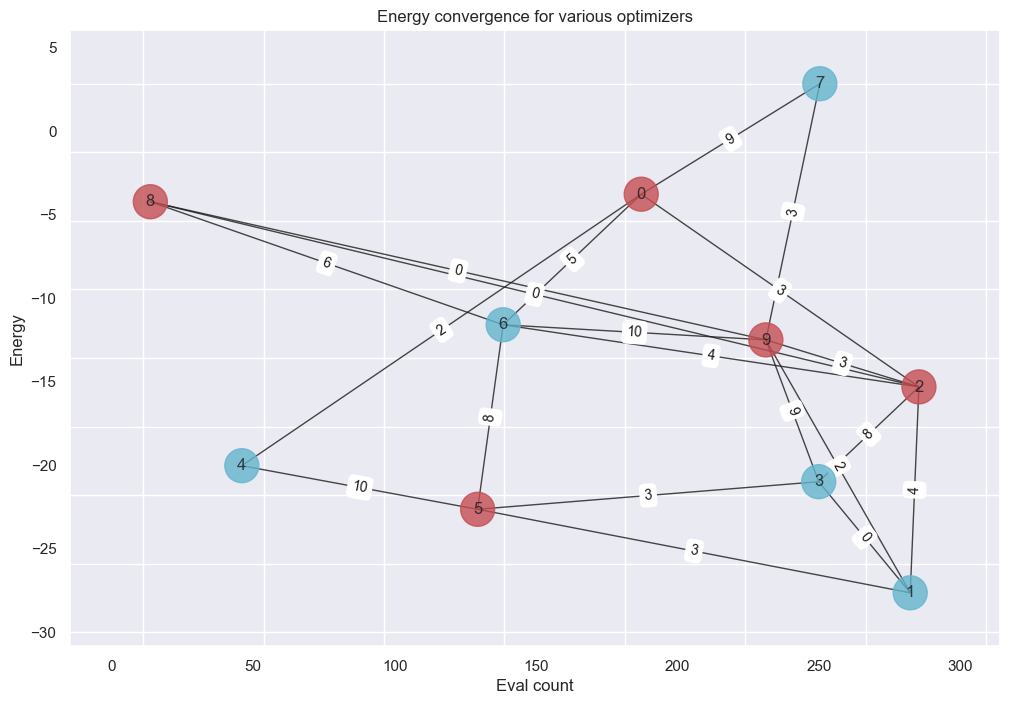

Problem name: Max-cut

Maximize
  -6*x_0*x_2 - 4*x_0*x_4 - 10*x_0*x_6 - 18*x_0*x_7 - 8*x_1*x_2 - 6*x_1*x_5
  - 4*x_1*x_9 - 16*x_2*x_3 - 8*x_2*x_6 - 6*x_2*x_9 - 6*x_3*x_5 - 18*x_3*x_9
  - 20*x_4*x_5 - 16*x_5*x_6 - 12*x_6*x_8 - 20*x_6*x_9 - 6*x_7*x_9 + 19*x_0
  + 9*x_1 + 22*x_2 + 20*x_3 + 12*x_4 + 24*x_5 + 33*x_6 + 12*x_7 + 6*x_8 + 27*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -46.0
Ising Hamiltonian:
1.5 * IIIIIIIZIZ
+ 2.0 * IIIIIIIZZI
+ 4.0 * IIIIIIZZII
+ 1.0 * IIIIIZIIIZ
+ 1.5 * IIIIZIIIZI
+ 1.5 * IIIIZIZIII
+ 5.0 * IIIIZZIIII
+ 2.5 * IIIZIIIIIZ
+ 2.0 * IIIZIIIZII
+ 4.0 * IIIZZIIIII
+ 4.5 * IIZIIIIIIZ
+ 3.0 * IZIZIIIIII
+ 1.0 * ZIIIIIIIZI
+ 1.5 * ZIIIIIIZII
+ 4.5 * ZIIIIIZIII
+ 5.0 * ZIIZIIIIII
+ 1.5 * ZIZIIIIIII
objective function value: 86.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=0.0, x_9=0.0
status: SUCCESS

Best solution BRUTE FORCE = [0, 1, 0, 1, 1, 0, 1, 1, 0

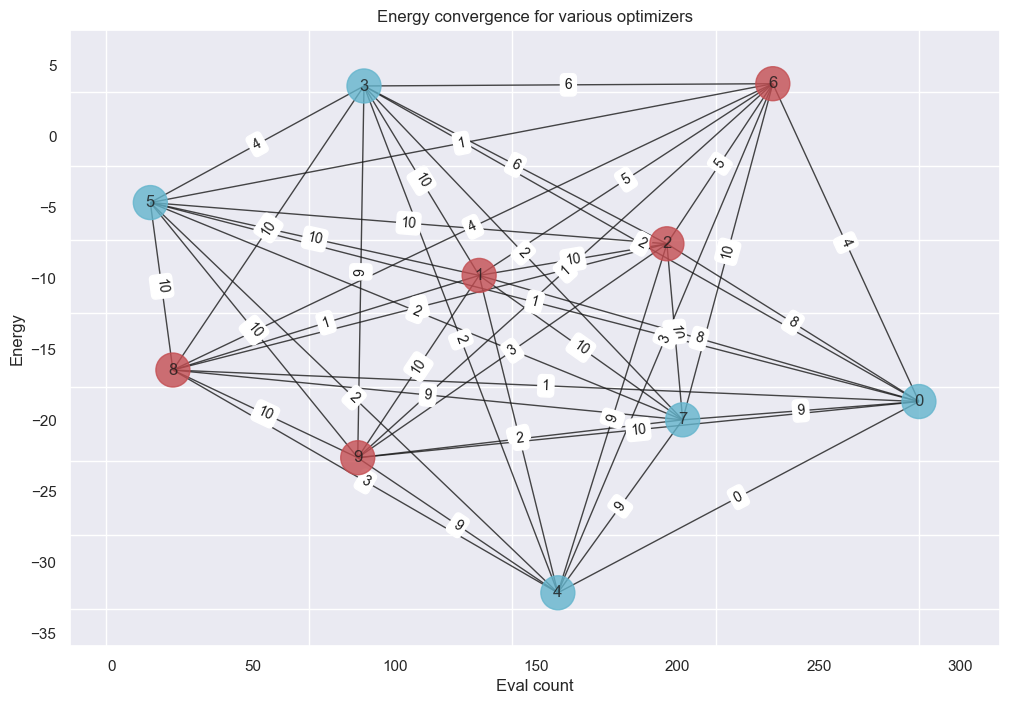

Problem name: Max-cut

Maximize
  -16*x_0*x_1 - 16*x_0*x_2 - 4*x_0*x_3 - 2*x_0*x_5 - 8*x_0*x_6 - 18*x_0*x_7
  - 2*x_0*x_8 - 20*x_0*x_9 - 20*x_1*x_2 - 20*x_1*x_3 - 14*x_1*x_4 - 20*x_1*x_5
  - 10*x_1*x_6 - 20*x_1*x_7 - 2*x_1*x_8 - 20*x_1*x_9 - 12*x_2*x_3 - 18*x_2*x_4
  - 20*x_2*x_5 - 10*x_2*x_6 - 20*x_2*x_7 - 8*x_2*x_8 - 6*x_2*x_9 - 4*x_3*x_4
  - 8*x_3*x_5 - 12*x_3*x_6 - 4*x_3*x_7 - 20*x_3*x_8 - 18*x_3*x_9 - 4*x_4*x_5
  - 6*x_4*x_6 - 18*x_4*x_7 - 6*x_4*x_8 - 18*x_4*x_9 - 2*x_5*x_6 - 4*x_5*x_7
  - 20*x_5*x_8 - 20*x_5*x_9 - 20*x_6*x_7 - 8*x_6*x_8 - 2*x_6*x_9 - 18*x_7*x_8
  - 4*x_7*x_9 - 20*x_8*x_9 + 43*x_0 + 71*x_1 + 65*x_2 + 51*x_3 + 44*x_4 + 50*x_5
  + 39*x_6 + 63*x_7 + 52*x_8 + 64*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -135.5
Ising Hamiltonian:
4.0 * IIIIIIIIZZ
+ 4.0 * IIIIIIIZIZ
+ 5.0 * IIIIIIIZZI
+ 1.0 * IIIIIIZIIZ
+ 5.0 * IIIIIIZIZI
+ 3.0 * IIIIIIZZII
+ 3.5 * IIIIIZIIZI
+ 4.5 * IIIIIZIZII
+ 1.0 * IIIIIZZIII
+ 0.5

In [ ]:
for i, graph_instance in enumerate(G_instances):
    print(f"\n{'-'*50}\nRunning Experiment for {graph_instance.graph_type}\n{'-'*50}\n")
    print(f"Instance Features for {graph_instance.graph_type}\n{'-'*50}\n")
    # Show instance features
    print(json.dumps(get_graph_features(graph_instance.G), indent=4))
    print(f"Solving Brute Force for {graph_instance.graph_type}\n{'-'*50}\n")
    G = graph_instance
    
    print(G)
    G.allocate_random_weights()
    G.compute_weight_matrix()
    print(G.weight_matrix)    
    G = graph_instance.G
    w = graph_instance.weight_matrix
    n = len(G.nodes())
    
    best_cost_brute = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i,j]*x[i]*(1-x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
    
    colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
    pos = nx.spring_layout(G)
    print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
    draw_graph(G, colors, pos)
    plt.show()
    
    



    max_cut = Maxcut(graph_instance.weight_matrix)
    qp = max_cut.to_quadratic_program()
    print(qp.prettyprint())

    qubitOp, offset = qp.to_ising()
    print("Offset:", offset)
    print("Ising Hamiltonian:")
    print(str(qubitOp))

    # solving Quadratic Program using exact classical eigensolver
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact.solve(qp)
    print(result.prettyprint())
    print('\nBest solution BRUTE FORCE = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))


    # Check that the Hamiltonian gives the right cost
    print(f"\n{'-'*10} Checking that current Hamiltonian gives right cost {'-'*10}\n")

    ee = NumPyMinimumEigensolver()

    # Calculate the min eigenvalue
    optimal_result = ee.compute_minimum_eigenvalue(qubitOp)

    ground_state = max_cut.sample_most_likely(optimal_result.eigenstate)
    print('ground state energy:', optimal_result.eigenvalue.real)
    print('optimal max-cut objective:', optimal_result.eigenvalue.real + offset)
    print('ground state solution:', ground_state)
    print('ground state objective:', qp.objective.evaluate(x))

    colors = ["r" if x[i] == 0 else "c" for i in range(n)]
    # draw_graph(G, colors, pos)


    ################################
    # Quantum Run -- VQE
    ################################

    print(f"\n{'-'*10} Simulating Instance on Quantum using VQE {'-'*10}\n")

    # Run optimisation code
    optimizer=COBYLA(maxiter=100)
    converge_cnts = np.empty([], dtype=object)
    converge_vals = np.empty([], dtype=object)
    num_qubits = qubitOp.num_qubits

    init_state = np.random.rand(num_qubits)*2*np.pi
    print(f"The initial state is {init_state}")
    n_restarts = 1
    optimizer_results = []

    result = {"algo": None,"result": None}


    ## Setting parameters for a run (Simulator Backend etc)
    algorithm_globals.random_seed = 12321
    seed = 10598
    backend = Aer.get_backend("aer_simulator_statevector")
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

    print(f"The initial state is {init_state}")

    n_restarts = 3


    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []

    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)

    for restart in range(n_restarts):
        print(f"Running Optimization at n_restart={restart}")
        init_state = np.random.rand(4)*2*np.pi

        # Define the systems of rotation for x and y
        ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")

        # VQE definition
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = vqe.compute_minimum_eigenvalue(qubitOp)

    # Convergence array
    total_counts = np.arange(0, len(counts))
    values = np.asarray(values)

    print(f"\n{'-'*10} Optimization Complete {'-'*10}\n")    

    pylab.rcParams['figure.figsize'] = (12, 8)
    pylab.plot(total_counts, values, label=type(optimizer).__name__)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Energy convergence for various optimizers')
    pylab.legend(loc='upper right')


    # Sample most liklely eigenstate
    x = max_cut.sample_most_likely(algo_result.eigenstate)
    print("Final energy:", algo_result.eigenvalue.real)
    print("time:", algo_result.optimizer_time)
    print("max-cut objective:", algo_result.eigenvalue.real + offset)
    print("solution:", x)
    print("solution objective:", qp.objective.evaluate(x))
    print("energy_gap:", algo_result.eigenvalue.real/optimal_result.eigenvalue.real)